In [120]:
# !pip install openseespy opsvis  #required in colab, not required in local environment
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops
import opsvis

In [ ]:
# unit 1 of park (Model 1)
mm = 1
kN  = 1
N = kN/1000
m = 1000*mm
MPa = N/mm**2

In [122]:
ops.wipe()
ops.model("Basic","-ndm",2,"-ndf",3)  #model is 2d with three degrees of freedom per node

In [123]:
DBeam = 457*mm #key
DCol = 406*mm   #key
beamPlasticHingeLength = DBeam/2  #originally divide by 2
# beamPlasticHingeLength = DBeam #originally divide by 2
columnPlasticHingeLength = DCol/2  #originally divide by 2

In [124]:
# Nodes definition
#left beam
#2-200 plastic hinge->heavy section discretization
ops.node(1,0,0)     #center node of the subassembles
ops.node(2,-DCol/4,0)  #left end of the rigid link
ops.node(200, -DCol/4 - beamPlasticHingeLength,0) #end of plastic hinge
ops.node(3,-848*mm,0)  #left end of the beam where gravity load is applied
ops.node(4,-2119*mm,0)  #extreme left end

#right beam
#500-5 plastic hinge->heavy section discretization
ops.node(5,DCol/4,0*mm)  #right rigid link
ops.node(500, +DCol/4 + beamPlasticHingeLength,0) #end of plastic hinge
ops.node(6,848*mm,0*mm)  #right beam where gravity load is applied
ops.node(7,2119*mm,0*mm)  #right extreme beam



#top column 8-800 rigid link
ops.node(8,0,DBeam/4*mm) #column top rigid link
ops.node(800,0,DBeam/4*mm + columnPlasticHingeLength) #column top rigid link
ops.node(9,0,1236*mm) #column top extreme->lateral displacement node

#bottom column
ops.node(10,0,-DBeam/4) #column bottom rigid link
ops.node(1000,0,-DBeam/4-columnPlasticHingeLength) #end of plastic hinge
ops.node(11,0,-1236*mm) #column bottom extreme

In [125]:
# ########################## Here we define the nodes for the columns ##############################
# 1236 is the distance of the extreme end of the column from the beam column joint center
differenceColumn = -DBeam/4-DCol/2 + 1236  #length of the column excluding plastic hinge length and rigid link lengths
numEleCol = 2
lengthEleCol = differenceColumn/numEleCol

[ops.node(51+i, 0, -DBeam/4 - columnPlasticHingeLength - i*lengthEleCol) for i in range(1,numEleCol)]   #for the bottom column

[ops.node(501+i, 0, +DBeam/4 + columnPlasticHingeLength + i*lengthEleCol) for i in range(1,numEleCol)] #for the top column

[None]

In [126]:

# ########################## Here we define the nodes for the beams ##############################
# lengthof the beam on eigher side is 2119 mm from the joint center
differenceBeam1 = -DCol/4 - DBeam/2 + 848 #this is the length of the beam upto the gravity loading point excluding pH length on either side
differenceBeam2 = -848 + 2119 #This is the length of the beam from the gravity load point to the extreme end

numEleBeam1 = 2
numEleBeam2 = 2
lengthEleBeam1 = differenceBeam1/numEleBeam1
lengthEleBeam2 = differenceBeam2/numEleBeam2  #These were used previously to discretize the beam when all the elements were modeled with distributed plasticity
# lengthEleBeam1 is for the elements right next to the plastic hinge zone
# lengthEleBeam3 is for the elements right next to the  nodes with gravity loads


#for the beam to the left of the joint
[ops.node(5001+i, -DCol/4 - beamPlasticHingeLength - i*lengthEleBeam1, 0) for i in range(1,numEleBeam1)]  
[ops.node(5051+i, -848 - i*lengthEleBeam2, 0) for i in range(1,numEleBeam2)]


#for the beam to the right of the joint
[ops.node(6001+i, +DCol/4 + beamPlasticHingeLength + i*lengthEleBeam1, 0) for i in range(1,numEleBeam1)]  
[ops.node(6051+i, +848 + i*lengthEleBeam2, 0) for i in range(1,numEleBeam2)]


[None]

In [127]:
#here we give section definitions using fiber sections, could have used RCSection2d as well!!
#two different sections have been defined for each columns and beams
#one heavily discretized section for plastic hinge regions and one lightly discretized section for the rest of the member length
# 1->plastic hinge section for beam
# 2->sections other than plastic hinge section for beam
# 3->plastic hinge section for column
# 1->sections other than plastic hinge section for column
transfTag = 1
ops.geomTransf("Linear",transfTag)
# ops.rigidLink("-beam",1,2)
# ops.rigidLink("-beam",1,8)
# ops.rigidLink("-beam",1,5)
# ops.rigidLink("-beam",1,10)
fck = 39.1
Econc = 5000*np.sqrt(fck) *MPa*0.7  #as per IS 456:2000 code
# I_rig  = 1e10
# A_rig = 1e10
# ops.element("elasticBeamColumn",100,1,2,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",101,1,8,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",102,1,5,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",103,1,10,A_rig,E_rig,I_rig,transfTag)



secTagBeamAtPlasticHinges = 1
secTagBeam = 2
secTagColumnAtPlasticHinges = 3
secTagColumn = 4

(np.float64(125.95),
 np.float64(-125.95),
 np.float64(-251.35),
 np.float64(251.35))

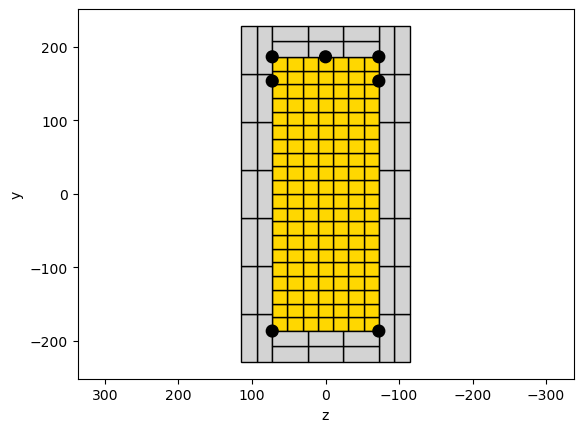

In [128]:

# ################################### For beam:  ##########################
#defining these parameters so that elements outside of the plastic hinge length can be modeled as elastic beam column elements
#These are to be changed while defining sections, hence key parameters for the research work
Bbeam = 229*mm  #key
Hbeam = 457*mm  #key

#may be i would benefit from using the elastic section for the elastic beam column elements
#  as i have already defined the fiber section layout here
Ibeam = 0.35 * Bbeam*Hbeam**3/12
Abeam = Bbeam*Hbeam
c = 42*mm  # cover  #consistent

y1col = Hbeam/2.0
z1col = Bbeam/2.0
separation_between_bars = 33*mm
y2col = y1col - c - separation_between_bars

nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 7
nFib = 7
nFibCover, nFibCore = 2, 20
As9 = np.pi*16**2/4  #6 #9 bars for compression and tension face  #key
Fy = 294 * N/mm**2  #done   #key



# uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
# ops.uniaxialMaterial("Concrete02", 2, -39*MPa, -0.002,-0.2*39*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete
ops.uniaxialMaterial("Concrete02", 2, -39*MPa, -0.002,0*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete

# ops.uniaxialMaterial("Concrete02", 3, -48*MPa, -0.003,-0.2*48*MPa,-0.01,0.3,2*MPa,3.6e3)   #confined concrete
ops.uniaxialMaterial("Concrete02", 3, -48*MPa, -0.003,0*MPa,-0.01,0.3,2*MPa,3.6e3)   #confined concrete

# uniaxialMaterial('Steel02', matTag, Fy, E0, b, *params, a1=a2*Fy/E0, a2=1.0, a3=a4*Fy/E0, a4=1.0, sigInit=0.0)
# R0=between 10 and 20, cR1=0.925, cR2=0.15
# D16 Rebar - Beam
# uniaxialMaterial     Steel02     2002     295000000.00000     210000000000.00000     0.00400     20.00000     0.92500     0.15000
fyBeamRebar = 295*MPa
# EBeamRebar =  0.35*210e3*MPa
EBeamRebar =  210e3*MPa
ops.uniaxialMaterial('Steel02', 4, fyBeamRebar,EBeamRebar , 0.004, 20,0.925,0.15) #material for rebar
# ops.uniaxialMaterial("Steel02",3,2500)  #material for unconfined concrete
# ops.uniaxialMaterial("Elastic",3,2500)  #material for confined concrete
# ops.uniaxialMaterial("Elastic",4,2500)   #material for rebar


beamSectionAtPlasticHinges = [['section', 'Fiber', secTagBeamAtPlasticHinges, '-GJ', 1.0e6],
             ['patch', 'rect', 3, nFibCore, nFibZCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 4, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 4, 2, As9, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 4, 2, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(beamSectionAtPlasticHinges)

nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 5
nFib = 5
nFibCover, nFibCore = 2, 4

beamSection = [['section', 'Fiber', secTagBeam, '-GJ', 1.0e6],
             ['patch', 'rect', 2, nFibCore, nFibZCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 4, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 4, 2, As9, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 4, 2, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(beamSection)

matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
opsvis.plot_fiber_section(beamSectionAtPlasticHinges, matcolor=matcolor)
plt.axis('equal')


# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsvis.plot_fiber_section(beamSection, matcolor=matcolor)
# plt.axis('equal')
# plt.show()

In [129]:
# ############################################## For column: #######################################

#defining these parameters so that elements outside of the plastic hinge length can be modeled as elastic beam column elements
Bcol = 305*mm
Hcol = 406*mm
Icol = 0.7 * Bbeam*Hbeam**3/12
Acol = Bcol*Hcol


# L_RL_beam = Hcol/4
# L_RL_col = Hbeam/4

c = 43*mm  # cover

y1col = Hcol/2.0
z1col = Bcol/2.0

fyColumnRebar = 500*MPa
# fyColumnRebar = 295*MPa
# EColumnRebar = 0.7*210e3*MPa
EColumnRebar = 200e3*MPa

# nFibZ = 1  #do separate discretization for the core and the cover later
# nFib = 20
nFibCover,nFibCover2, nFibCore = 4,2, 16
nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 7
nFib = 7
nFibCover, nFibCore = 2, 20
# As9 = 1*mm*mm  #four #9 bars cover is 2.5 mmes
# uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
ops.uniaxialMaterial("Concrete02", 5, -39*MPa, -0.002,-0.2*39*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete
ops.uniaxialMaterial("Concrete02", 6, -48*MPa, -0.003,-0.2*48*MPa,-0.01,0.3,2*MPa,3.6e3)  #confined concrete
# # ops.uniaxialMaterial("Elastic",6,2500)  #material for unconfined concrete
# # ops.uniaxialMaterial("Elastic",7,2500)   #material for rebar
# # ops.uniaxialMaterial('Steel02', 7, fyColumnRebar, EColumnRebar, 0.004, 20,0.925,0.15)
ops.uniaxialMaterial('Steel02', 7, fyColumnRebar, EColumnRebar, 0.004, 20,0.925,0.15) #material for rebar




columnSectionAtPlasticHinges = [['section', 'Fiber', secTagColumnAtPlasticHinges, '-GJ', 1.0e6],
             ['patch', 'rect', 6, nFibCore, nFibCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 7, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 7, 2, As9, 0, z1col-c, 0, c-z1col],
             ['layer', 'straight', 7, 3, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(columnSectionAtPlasticHinges)

#column section at places other than plastic hinges
nFibCover,nFibCover2, nFibCore = 4,2, 8 #at sections other than plastic hinges
columnSection = [['section', 'Fiber', secTagColumn, '-GJ', 1.0e6],
             ['patch', 'rect', 5, nFibCore, nFibCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 7, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 7, 2, As9, 0, z1col-c, 0, c-z1col],
             ['layer', 'straight', 7, 3, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(columnSection)


# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsvis.plot_fiber_section(columnSectionAtPlasticHinges, matcolor=matcolor)
# plt.axis('equal')

# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsvis.plot_fiber_section(columnSection, matcolor=matcolor)
# plt.axis('equal')

# matcolor = ['r', 'lightgrey', 'gold', 'w', 'lightgrey', 'gold','w']
# opsvis.plot_fiber_section(columnSection, matcolor=matcolor)
# plt.axis('equal')

# # element('elasticBeamColumn', eleTag, *eleNodes, secTag, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
# # ops.element("elasticBeamColumn",1,1,2,secTagColumn,transfTag)
# # ops.element("elasticBeamColumn",2,2,3,secTagColumn,transfTag)
# # ops.element("elasticBeamColumn",3,2,4,secTagBeam,transfTag)

In [130]:
# here we define the beam integration rules for the different elements
# by default integration points are set to be 5 for each element
#could be taken higher for elements in the plastic hinge regions
integrationTagBeamPlasticHinges = 1
integrationTagBeam = 2

integrationTagColumn = 3
integrationTagColumnPlasticHinges = 4

# # beamIntegration('Lobatto', tag, secTag, N)
ops.beamIntegration("Lobatto",integrationTagBeamPlasticHinges, secTagBeamAtPlasticHinges, 5)
ops.beamIntegration("Lobatto",integrationTagBeam, secTagBeam, 5)

ops.beamIntegration("Lobatto",integrationTagColumnPlasticHinges,secTagColumnAtPlasticHinges, 5)
ops.beamIntegration("Lobatto",integrationTagColumn,secTagColumn, 5)

In [131]:
#################### left beam of the plastic hinge region#############
# # ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0)
ops.element("dispBeamColumn", 1, *[200,2], transfTag, integrationTagBeamPlasticHinges) #left beam plastic hinge region

# first beam to the left of the plastic hinge region for the left beam which is to be omitted for an external joint
# this lump of code you see is because the first and last elements connect different nodes that don't fit into a pattern and 
# the middle ones connect the consecutive nodes, for example, for first beam on the left outside of the ph connects node 200 to node 5002
# and the last connects the final node in the pattern to the gravity loading node 3, here 5002 to 3

for i in range(1,numEleBeam1+1):
  if i == 1:
    # ops.element('dispBeamColumn',5000+i,*[5002,200],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",5000+i,*[5002,200],Abeam,Econc,Ibeam,transfTag )
  elif i== numEleBeam1:
    # ops.element('dispBeamColumn',5000+i,*[3,5000+i],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",5000+i,*[3,5000+i],Abeam,Econc,Ibeam,transfTag)  #first and last elements have different initial and final nodes that don't fit into a pattern
  else:
    # ops.element('dispBeamColumn', 5000+i, *[5000+i+1,5000+i], transfTag, integrationTagBeam) #first beam to the left
    ops.element("elasticBeamColumn", 5000+i, *[5000+i+1,5000+i], Abeam,Econc,Ibeam,transfTag) #first beam to the left outside of the plastic hinge region
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

for i in range(1,numEleBeam2+1):
  if i == 1:
    # ops.element('dispBeamColumn',5050+i,*[5052,3],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",5050+i,*[5052,3],Abeam,Econc,Ibeam,transfTag)
  elif i== numEleBeam2:
    # ops.element('dispBeamColumn',5050+i,*[4,5050+i],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",5050+i,*[4,5050+i],Abeam,Econc,Ibeam,transfTag)
  else:
    # ops.element('dispBeamColumn', 5050+i, *[5050+i+1,5050+i], transfTag, integrationTagBeam) #first beam to the left
    ops.element("elasticBeamColumn", 5050+i, *[5050+i+1,5050+i],Abeam,Econc,Ibeam,transfTag) #first beam to the left
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

In [132]:
#################### right beam of the plastic hinge region#############

ops.element("dispBeamColumn", 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
# ops.element('dispBeamColumn', 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
for i in range(1,numEleBeam1+1):
  if i == 1:
    # ops.element('dispBeamColumn',6000+i,*[500,6002],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",6000+i,*[500,6002],Abeam,Econc,Ibeam,transfTag)
  elif i== numEleBeam1:
    # ops.element('dispBeamColumn',6000+i,*[6000+i,6],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",6000+i,*[6000+i,6],Abeam,Econc,Ibeam,transfTag)
  else:
    # ops.element('dispBeamColumn', 6000+i, *[6000+i,6000+i+1], transfTag, integrationTagBeam) #first beam to the right till the gravity load point
    ops.element("elasticBeamColumn",6000+i,*[6000+i,6000+i+1],Abeam,Econc,Ibeam,transfTag)
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

for i in range(1,numEleBeam2+1):
  if i == 1:
    # ops.element('dispBeamColumn',6050+i,*[6,6052],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",6050+i,*[6,6052],Abeam,Econc,Ibeam,transfTag)
  elif i== numEleBeam2:
    # ops.element('dispBeamColumn',6050+i,*[6050+i,7],transfTag, integrationTagBeam)
    ops.element("elasticBeamColumn",6050+i,*[6050+i,7],Abeam,Econc,Ibeam,transfTag)
  else:
    # ops.element('dispBeamColumn', 6050+i, *[6050+i,6050+i+1], transfTag, integrationTagBeam) #beam to the right of the gravity load point
    ops.element("elasticBeamColumn",6050+i,*[6050+i,6050+i+1],Abeam,Econc,Ibeam,transfTag)
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

In [133]:
#bottom columns for the beam column joint
# ops.element('dispBeamColumn', 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
# ops.element('dispBeamColumn', 5, *[500,6], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 6, *[6,7], transfTag, integrationTagBeam) #beam
ops.element('dispBeamColumn', 7, *[10,1000], transfTag, integrationTagColumnPlasticHinges)  #bottom column
for i in range(1,numEleCol+1):
  if i == 1:
    ops.element('dispBeamColumn',50+i,*[1000,52],transfTag, integrationTagColumn)
  elif i== numEleCol:
    ops.element('dispBeamColumn',50+i,*[50+i,11],transfTag, integrationTagColumn)
  else:
    ops.element('dispBeamColumn', 50+i, *[50+i,50+i+1], transfTag, integrationTagColumn)  #bottom column
# ops.element('dispBeamColumn', 8, *[1000,11], transfTag, integrationTagColumn)  #bottom column

In [134]:
# top columns for the beam column joint
ops.element('dispBeamColumn', 9, *[8,800], transfTag, integrationTagColumnPlasticHinges)  #top column
for i in range(1,numEleCol+1):
  if i == 1:
    ops.element('dispBeamColumn',500+i,*[800,502],transfTag, integrationTagColumn)
  elif i== numEleCol:
    ops.element('dispBeamColumn',500+i,*[500+i,9],transfTag, integrationTagColumn)
  else:
    ops.element('dispBeamColumn', 500+i, *[500+i,500+i+1], transfTag, integrationTagColumn)  #top column

# element('dispBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-cMass', '-mass', mass=0.0)

In [135]:
#define the fixities for the points
ops.fix(4,0,1,0)
ops.fix(7,0,1,0)
# ops.fix(9,0,1,0)
ops.fix(11,1,1,0)

In [136]:
# [{eleTag: ops.eleNodes(eleTag)} for eleTag in ops.getEleTags() if eleTag >6000 and eleTag<7000]

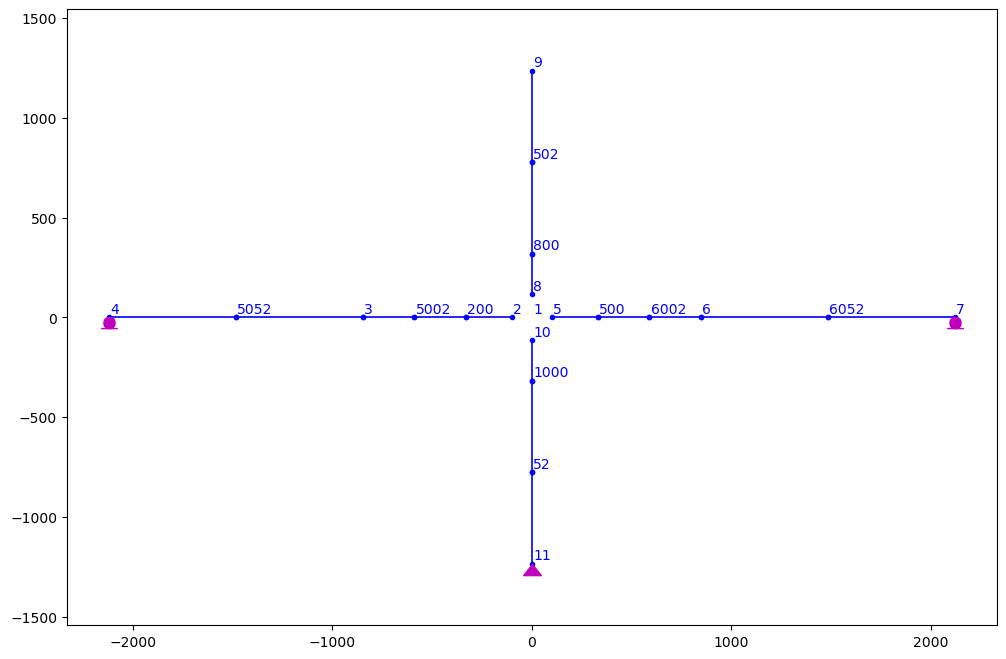

In [137]:
# opsvis.plot_model(node_labels = False, gauss_points = False)
opsvis.plot_model(element_labels = False, gauss_points = False)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [138]:
# define the rigid links
ops.rigidLink("-beam",1,8)
ops.rigidLink("-beam",1,5)
ops.rigidLink("-beam",1,10)
ops.rigidLink("-beam",1,2)


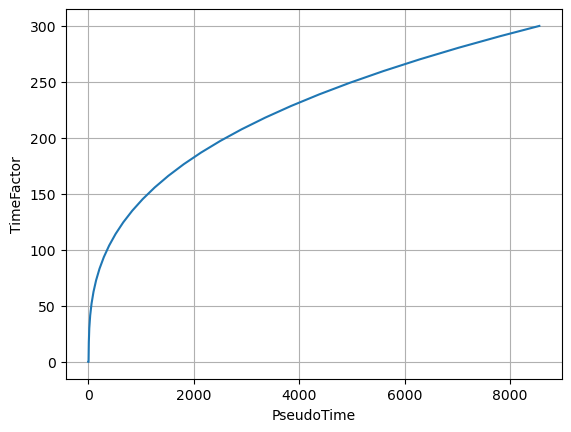

In [139]:
NN = 2
def defineTimeFactorHistory1(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = []
    for j,thisPeak in enumerate(peaksArray):
        for i in range(nCycles):
            timeFactor = np.append(timeFactor,np.linspace(0,thisPeak*scaleFactor,nSteps*j**3))
            timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps*j**3))
            timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps*j**3))
def defineTimeFactorHistoryMonotonic(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = [0]
    for j,thisPeak in enumerate(peaksArray):
        timeFactor = np.append(timeFactor,np.linspace(timeFactor[-1],thisPeak*scaleFactor,nSteps*j**NN,endpoint  = False))
            # timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps*j**3))
            # timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps*j**3))
    plt.plot(timeFactor)
    plt.grid()
    plt.xlabel('PseudoTime')
    plt.ylabel('TimeFactor')
    plt.show()
    return timeFactor
# def defineTimeFactorHistoryMonotonic(peaksArray, scaleFactor, nSteps, nCycles, NN=1):
#     timeFactor = [0.0]
#     for j, thisPeak in enumerate(peaksArray, start=1):
#         nPts = int(nSteps * j**NN)
#         start = timeFactor[-1]
#         end = thisPeak * scaleFactor
#         newSegment = np.linspace(start, end, nPts, endpoint=False)
#         timeFactor = np.append(timeFactor, newSegment)

#     plt.plot(timeFactor)
#     plt.grid(True)
#     plt.xlabel('PseudoTime')
#     plt.ylabel('TimeFactor')
#     plt.show()

#     return timeFactor

def defineTimeFactorHistory(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = []
    for j,thisPeak in enumerate(peaksArray):
        for i in range(nCycles):
            timeFactor = np.append(timeFactor,np.linspace(0,thisPeak*scaleFactor,nSteps))
            timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps))
            timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps))

    plt.plot(timeFactor)
    plt.grid()
    plt.xlabel('PseudoTime')
    plt.ylabel('TimeFactor')
    plt.show()
    return timeFactor


# peaksArray=np.array([11.11,29.6,44.4,59.2,74.0,88.8,103.6,]) #in mm
peaksArray=np.linspace(0,300,30,endpoint=True) #in mm  set this to 0,300,30 for plastic hinge length of D/2
scaleFactor = 1.0
nSteps = 1
nCycles = 1
timeFactorHistory=defineTimeFactorHistoryMonotonic(peaksArray,scaleFactor,nSteps,nCycles)


after: 100 iterations  current Norm: 0.000637994 (max: 1e-08, Norm deltaR: 1412.89)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 7 with domain at load factor 0.8
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000194784 (max: 1e-08, Norm deltaR: 43.5806)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 78.0486
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000194784 (max: 1e-07, Norm deltaR: 43.5806)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 78.0486
OpenSees > analyze failed, returned: -3 error flag


The freeEndDisp has been equal to 1.6266453643204887e-16 at the load of 1.0861055366341163e-15.
The freeEndDisp has been equal to 5.172413793103448 at the load of 28.427026217774625.
The freeEndDisp has been equal to 10.344827586206897 at the load of 53.68619037424716.
The freeEndDisp has been equal to 15.517241379310345 at the load of 70.19411951414509.
The freeEndDisp has been equal to 15.517241379310345 at the load of 70.1941195141451.
The freeEndDisp has been equal to 17.24137931034483 at the load of 71.34276506973222.
The freeEndDisp has been equal to 18.96551724137931 at the load of 72.06784648431821.
The freeEndDisp has been equal to 20.689655172413794 at the load of 72.73454282926369.
The freeEndDisp has been equal to 22.413793103448278 at the load of 73.31703319440811.
The freeEndDisp has been equal to 24.13793103448276 at the load of 73.90014549572402.
The freeEndDisp has been equal to 25.862068965517242 at the load of 74.47289733720338.
The freeEndDisp has been equal to 27.5

after: 100 iterations  current Norm: 0.000316871 (max: 1e-08, Norm deltaR: 352.825)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.8097
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000316871 (max: 1e-07, Norm deltaR: 352.825)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.8097
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000316871 (max: 1e-06, Norm deltaR: 352.825)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.8097
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 4.90183e-05 (max: 1e-08,

The freeEndDisp has been equal to 83.11259388427595 at the load of 81.8487993904054.
The freeEndDisp has been equal to 83.24234524001083 at the load of 81.86780485819139.
The freeEndDisp has been equal to 83.37209659574572 at the load of 81.8873355120241.
The freeEndDisp has been equal to 83.5018479514806 at the load of 81.90686199690035.
The freeEndDisp has been equal to 83.63159930721548 at the load of 81.92638426740277.
The freeEndDisp has been equal to 83.76135066295038 at the load of 81.94590184882126.
The freeEndDisp has been equal to 83.89110201868526 at the load of 81.96541491701232.
The freeEndDisp has been equal to 84.02085337442014 at the load of 81.98492335712702.
The freeEndDisp has been equal to 84.15060473015502 at the load of 82.00442739177169.
The freeEndDisp has been equal to 84.2803560858899 at the load of 82.02392698185449.
The freeEndDisp has been equal to 84.41010744162479 at the load of 82.04342205852335.
The freeEndDisp has been equal to 84.53985879735968 at the

after: 100 iterations  current Norm: 0.0147214 (max: 1e-08, Norm deltaR: 97.1646)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 82.5544
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.0147214 (max: 1e-07, Norm deltaR: 97.1646)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 82.5544
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.0147214 (max: 1e-06, Norm deltaR: 97.1646)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 82.5544
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 202.889 (max: 1e-08, Norm delt

The freeEndDisp has been equal to 88.82165353661087 at the load of 66.30176872242603.
The freeEndDisp has been equal to 88.95140489234575 at the load of 66.52058511276296.
The freeEndDisp has been equal to 89.08115624808065 at the load of 66.73545478095167.
The freeEndDisp has been equal to 89.21090760381553 at the load of 66.94145297779812.
The freeEndDisp has been equal to 89.34065895955041 at the load of 67.13920188368688.
The freeEndDisp has been equal to 89.47041031528529 at the load of 67.33039161388466.
The freeEndDisp has been equal to 89.60016167102017 at the load of 67.60381955518744.
The freeEndDisp has been equal to 89.72991302675506 at the load of 67.87534518437029.
The freeEndDisp has been equal to 89.85966438248995 at the load of 68.14033204044047.
The freeEndDisp has been equal to 89.98941573822484 at the load of 68.3913382694751.
The freeEndDisp has been equal to 90.11916709395972 at the load of 68.6404307850231.
The freeEndDisp has been equal to 90.2489184496946 at th

after: 100 iterations  current Norm: 1.61917e-05 (max: 1e-08, Norm deltaR: 5.36819)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 72.9172
OpenSees > analyze failed, returned: -3 error flag


The freeEndDisp has been equal to 218.41750595780098 at the load of 72.95934766409553.
The freeEndDisp has been equal to 218.438928156256 at the load of 73.00860952850785.
The freeEndDisp has been equal to 218.46035035471104 at the load of 73.05784034039638.
The freeEndDisp has been equal to 218.48177255316605 at the load of 73.10703917165625.
The freeEndDisp has been equal to 218.50319475162107 at the load of 73.15620504673333.
The freeEndDisp has been equal to 218.5246169500761 at the load of 73.20533694088253.
The freeEndDisp has been equal to 218.54603914853112 at the load of 73.25443377839099.
The freeEndDisp has been equal to 218.56746134698616 at the load of 73.30349443077104.
The freeEndDisp has been equal to 218.58888354544118 at the load of 73.35251771491673.
The freeEndDisp has been equal to 218.6103057438962 at the load of 73.40150239123017.
The freeEndDisp has been equal to 218.63172794235123 at the load of 73.45044716171294.
The freeEndDisp has been equal to 218.653150140

after: 100 iterations  current Norm: 3.89375e-05 (max: 1e-08, Norm deltaR: 26.8422)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.6761
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00641447 (max: 1e-08, Norm deltaR: 1011.68)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.6947
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00641447 (max: 1e-07, Norm deltaR: 1011.68)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.6947
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00641447 (max: 1e-06, No

The freeEndDisp has been equal to 223.73021117464722 at the load of 81.67610748703413.
The freeEndDisp has been equal to 223.75163337310224 at the load of 81.70198056788963.
The freeEndDisp has been equal to 223.77305557155728 at the load of 81.72431144001732.
The freeEndDisp has been equal to 223.7944777700123 at the load of 81.74999549778836.
The freeEndDisp has been equal to 223.8158999684673 at the load of 81.77557724708484.
The freeEndDisp has been equal to 223.83732216692235 at the load of 81.80105535469566.
The freeEndDisp has been equal to 223.85874436537736 at the load of 81.82645894829808.
The freeEndDisp has been equal to 223.8801665638324 at the load of 81.85026477838373.
The freeEndDisp has been equal to 223.90158876228742 at the load of 81.8754303651096.
The freeEndDisp has been equal to 223.92301096074243 at the load of 81.9004876364071.
The freeEndDisp has been equal to 223.94443315919747 at the load of 81.92543537100859.
The freeEndDisp has been equal to 223.9658553576

after: 100 iterations  current Norm: 0.00044579 (max: 1e-08, Norm deltaR: 36.9091)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 82.6297
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00044579 (max: 1e-07, Norm deltaR: 36.9091)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 82.6297
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 2.07031e-05 (max: 1e-08, Norm deltaR: 1.62464)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 83.4442
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 3.63265e-07 (max: 1e-08, N

The freeEndDisp has been equal to 276.6670130703643 at the load of 83.45914914165891.
The freeEndDisp has been equal to 276.6812245314246 at the load of 83.45826297400862.
The freeEndDisp has been equal to 276.695435992485 at the load of 83.45728489904619.
The freeEndDisp has been equal to 276.7096474535453 at the load of 83.45621422404184.
The freeEndDisp has been equal to 276.7238589146056 at the load of 83.45505024608887.
The freeEndDisp has been equal to 276.738070375666 at the load of 83.45379225171922.
The freeEndDisp has been equal to 276.7522818367263 at the load of 83.452439516669.
The freeEndDisp has been equal to 276.7664932977866 at the load of 83.45099130564125.
The freeEndDisp has been equal to 276.780704758847 at the load of 83.44944687206142.
The freeEndDisp has been equal to 276.7949162199073 at the load of 83.44780545782623.
The freeEndDisp has been equal to 276.8091276809676 at the load of 83.44606629304502.
The freeEndDisp has been equal to 276.823339142028 at the l

after: 100 iterations  current Norm: 2.22135e-06 (max: 1e-08, Norm deltaR: 1.37795)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 83.4403
OpenSees > analyze failed, returned: -3 error flag


The freeEndDisp has been equal to 278.96926976213825 at the load of 80.51583401777334.
The freeEndDisp has been equal to 278.98348122319857 at the load of 80.48703070007446.
The freeEndDisp has been equal to 278.9976926842589 at the load of 80.45820029517276.
The freeEndDisp has been equal to 279.01190414531925 at the load of 80.42934284619506.
The freeEndDisp has been equal to 279.02611560637956 at the load of 80.4004583950091.
The freeEndDisp has been equal to 279.0403270674399 at the load of 80.37154698224734.
The freeEndDisp has been equal to 279.05453852850025 at the load of 80.34260864733308.
The freeEndDisp has been equal to 279.06874998956056 at the load of 80.31364342850401.
The freeEndDisp has been equal to 279.08296145062087 at the load of 80.28465136283539.
The freeEndDisp has been equal to 279.09717291168124 at the load of 80.25563248626389.
The freeEndDisp has been equal to 279.11138437274155 at the load of 80.22658683361051.
The freeEndDisp has been equal to 279.12559583

after: 100 iterations  current Norm: 3.34205e-06 (max: 1e-08, Norm deltaR: 0.939457)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.7765
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00239298 (max: 1e-08, Norm deltaR: 608.804)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.7936
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000422124 (max: 1e-08, Norm deltaR: 54.6924)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 81.9987
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 4.48207e-06 (max: 1e-08,

The freeEndDisp has been equal to 295.61538350766597 at the load of 82.50167907000157.
The freeEndDisp has been equal to 295.62769984612754 at the load of 82.51882698315475.
The freeEndDisp has been equal to 295.6400161845892 at the load of 82.53595670453845.
The freeEndDisp has been equal to 295.6523325230508 at the load of 82.55306794893191.
The freeEndDisp has been equal to 295.6646488615124 at the load of 82.57016041089665.
The freeEndDisp has been equal to 295.676965199974 at the load of 82.58723377001859.
The freeEndDisp has been equal to 295.68928153843564 at the load of 82.60428773494478.
The freeEndDisp has been equal to 295.7015978768972 at the load of 82.62132205034479.
The freeEndDisp has been equal to 295.71391421535884 at the load of 82.63833650282506.
The freeEndDisp has been equal to 295.72623055382047 at the load of 82.6553309254322.
The freeEndDisp has been equal to 295.73854689228205 at the load of 82.67230520046485.
The freeEndDisp has been equal to 295.750863230743

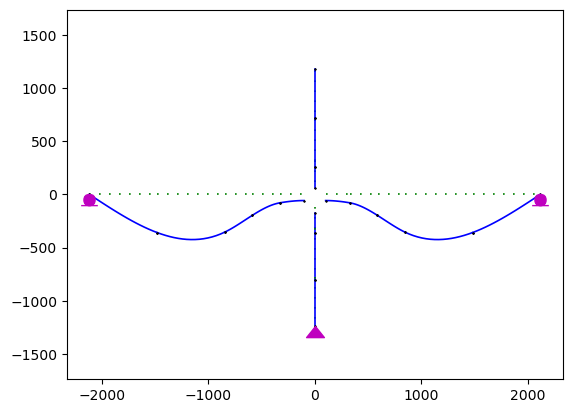

In [140]:
ops.timeSeries("Linear",10)
ops.pattern("Plain",10,10)
ops.load(3,0,-55*kN,0)
ops.load(6,0,-55*kN,0)


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("BandGeneral")
initialTolerance = 1e-8
ops.test("NormDispIncr",initialTolerance,100)
# integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
ops.integrator("LoadControl",0.1)
ops.algorithm("Newton")
ops.analysis("Static")
ok = ops.analyze(10)
ops.loadConst('-time', 0.0)
ops.wipeAnalysis()
# ops.setTime(0.0)
opsvis.plot_defo()

ops.timeSeries("Linear",1)  #Displacement control
ops.pattern("Plain",1,1)
ops.load(9,1,0,0)

# recorder('Element', '-file', filename, '-xml', filename, '-binary', filename, '-precision', nSD=6, '-timeSeries', tsTag, '-time', '-dT', deltaT=0.0, '-closeOnWrite', '-ele', *eleTags=[], '-eleRange', startEle, endEle, '-region', regionTag, *args)
# ops.recorder('Element', '-file', f"MomentCurvature_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-timeSeries', 1, '-time', '-ele', [5001,1], "section","force")
# ops.recorder('Element', '-file', f"Moment_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-time', '-ele', 1, "section","Force")
# ops.recorder('Element', '-file', f"Curvature_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-time', '-ele', 1, "section","deformation")


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("UmfPack")
initialTolerance = 1e-8 #initially 1e-8
ops.test("NormDispIncr",initialTolerance,100)
initialDisplacementIncrement  = timeFactorHistory[1] - timeFactorHistory[0]
# integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
ops.integrator("DisplacementControl",9,1,initialDisplacementIncrement,100)  #load to be applied at the tip of the beam free end
ops.algorithm("KrylovNewton")
ops.analysis("Static")
freeEndDisp = [ops.nodeDisp(9,1)]
loadFactor = [ops.getLoadFactor(1)]

ok = ops.analyze(1)
n = 1

freeEndDisp.append(ops.nodeDisp(9,1))
loadFactor.append(ops.getLoadFactor(1))

noOfAttempt = 0
while ok==0 and n<len(timeFactorHistory)-1:
# while ok==0 and n<20:

  displacementIncrement = timeFactorHistory[n+1] - timeFactorHistory[n]
  # print(displacementIncrement)
  ops.integrator("DisplacementControl",9,1,displacementIncrement,100)
  ok = ops.analyze(1)
  modifiedTolerance = initialTolerance*10
  noOfAttempt = 0
  while ok!=0 and noOfAttempt < 8: #initially 4 set to 6
    ops.test("NormDispIncr",modifiedTolerance,100)
    ok = ops.analyze(1)
    modifiedTolerance = modifiedTolerance*10
    noOfAttempt+=1
  if ok!=0:
    break
  ops.test("NormDispIncr",initialTolerance,100)
  freeEndDisp.append(ops.nodeDisp(9,1))
  print(f"The freeEndDisp has been equal to {ops.nodeDisp(9,1)} at the load of {ops.getLoadFactor(1)}.")
  loadFactor.append(ops.getLoadFactor(1))
  n+=1

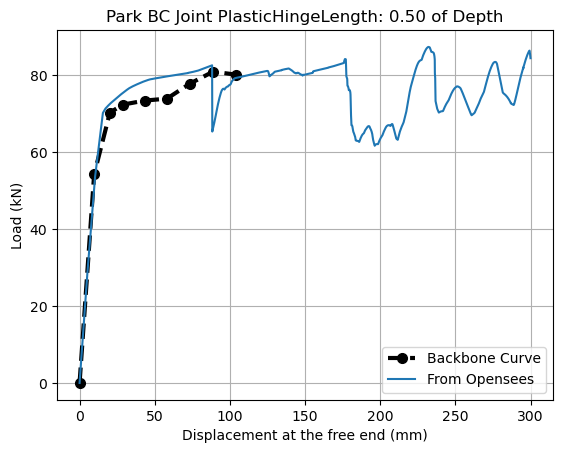

In [141]:
enveloperight = np.loadtxt(f"envelopeRightPark.txt")
plt.plot(enveloperight[:,1],enveloperight[:,0],'black', marker = "o",markersize = 7, linewidth = 3,ls = "--", label = "Backbone Curve")
# plt.plot(leftEnvelope[1,:],leftEnvelope[0,:],'black', marker = 'o',markersize = 7,linewidth = 3,ls = "--",)
loadFactor = np.array(loadFactor)
# loadFactor = loadFactor - loadFactor[0]
freeEndDisp = np.array(freeEndDisp)
# freeEndDisp = freeEndDisp - freeEndDisp[0]
plt.plot(freeEndDisp,loadFactor,label = "From Opensees")
plt.ylabel("Load (kN)")
plt.xlabel("Displacement at the free end (mm)")
plt.grid()
plt.legend(loc = "lower right")
# plt.title("Park BC Joint")
# from google.colab import files
plt.title(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth")
plt.savefig(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth.png")

# 3. Download the file
# files.download(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth.png")
plt.show()

In [142]:
maxDisp,maxLoad = freeEndDisp[np.where(loadFactor==np.max(loadFactor))[0][0]], np.max(loadFactor)
maxDisp, maxLoad #these are the values to be returned by the program #key

(np.float64(232.07184982186277), np.float64(87.36103653189912))

In [160]:
# I will track the first point from which the load deformation curve starts to fall down, that will be the point of maximum load, rest is ignored
maxLoad = loadFactor[np.where(np.diff(loadFactor)<0)[0][0]+1]
maxDisp = freeEndDisp[np.where(np.diff(loadFactor)<0)[0][0]+1]
maxDisp, maxLoad

(np.float64(61.76927681992338), np.float64(79.92038257488693))

In [143]:
np.where(loadFactor==np.max(loadFactor))[0][0]

np.int64(4026)

np.float64(299.98768366153837)

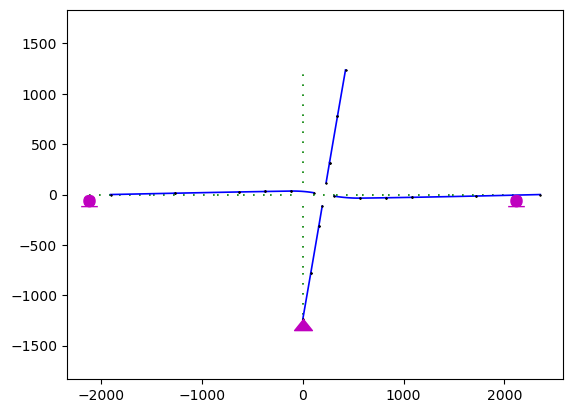

In [144]:
opsvis.plot_defo()
# print(loadFactor[0])
timeFactorHistory[-1]

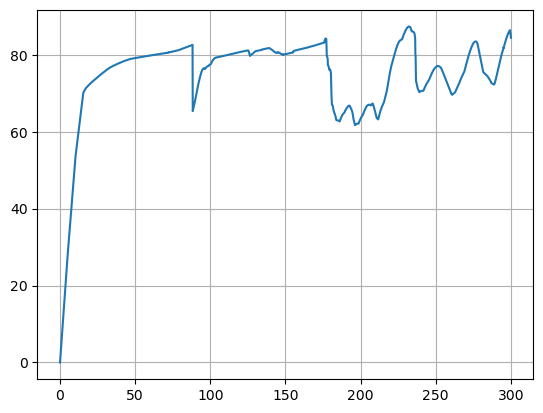

In [145]:
plt.plot(freeEndDisp,loadFactor)
plt.grid()

In [146]:
data = ops.eleResponse(1,"section",1,"fiberData")
y = data[0:len(data):5]
z = data[1:len(data):5]
A = data[2:len(data):5]
sig = data[3:len(data):5]
strain = data[4:len(data):5]

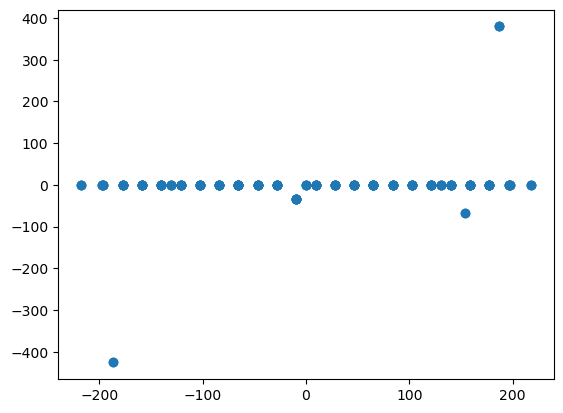

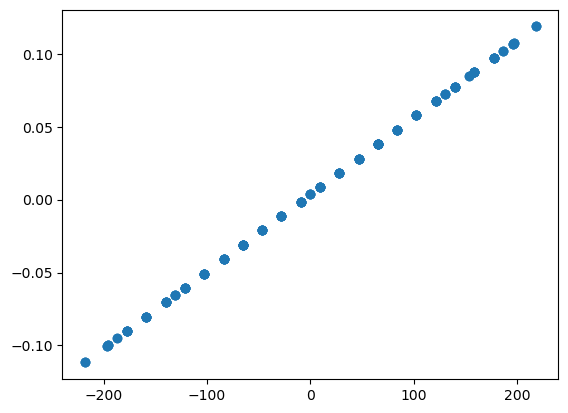

In [147]:
plt.scatter(y,np.array(sig)*1000)
plt.show()
plt.scatter(y,np.array(strain))